In [1]:
import numpy as np
import pandas as pd
import reciprocalspaceship as rs
import gemmi

In [2]:
import matplotlib.pyplot as plt

### Read in data

In [3]:
mtz_path = "../PTP1B_DK/recons_mtzs/PTP1B-y0049_mrflagsref_idxs_recons.mtz"
bound_pdb_path = "../PTP1B_DK/bound_state_models/PTP1B-y0049_refmac_input.split.bound-state.pdb"

In [4]:
diff_mtz = rs.read_mtz(mtz_path)

In [5]:
len(diff_mtz)

49426

In [6]:
diff_mtz = diff_mtz[["F-obs-diff", "PHIFOFCWT"]].dropna()

In [7]:
diff_mtz.keys()

Index(['F-obs-diff', 'PHIFOFCWT'], dtype='object')

### Determine ligand position in pdb

In [8]:
bound_pdb = gemmi.read_pdb(bound_pdb_path)

In [9]:
list(bound_pdb[0])

[<gemmi.Chain A with 281 res>,
 <gemmi.Chain B with 1 res>,
 <gemmi.Chain C with 1 res>,
 <gemmi.Chain S with 266 res>]

In [10]:
ligand = bound_pdb[0][1]

In [11]:
list(ligand[0])

[<gemmi.Atom C01 at (-30.1, 28.1, -13.1)>,
 <gemmi.Atom C03 at (-29.2, 25.7, -13.5)>,
 <gemmi.Atom C04 at (-29.4, 24.9, -12.3)>,
 <gemmi.Atom C06 at (-31.6, 24.5, -13.3)>,
 <gemmi.Atom C07 at (-31.7, 26.0, -13.1)>,
 <gemmi.Atom C08 at (-30.6, 22.6, -11.8)>,
 <gemmi.Atom C11 at (-31.7, 20.4, -11.4)>,
 <gemmi.Atom C12 at (-31.7, 19.3, -12.1)>,
 <gemmi.Atom C13 at (-31.7, 18.0, -11.6)>,
 <gemmi.Atom C14 at (-31.7, 17.8, -10.2)>,
 <gemmi.Atom C15 at (-31.7, 19.0, -9.4)>,
 <gemmi.Atom C16 at (-31.7, 20.3, -10.0)>,
 <gemmi.Atom F17 at (-31.8, 16.6, -9.6)>,
 <gemmi.Atom N02 at (-30.4, 26.7, -13.7)>,
 <gemmi.Atom N05 at (-30.5, 23.9, -12.5)>,
 <gemmi.Atom N10 at (-31.7, 21.7, -12.0)>,
 <gemmi.Atom O09 at (-29.6, 22.3, -11.1)>,
 <gemmi.Atom H011 at (-30.9, 28.3, -12.3)>,
 <gemmi.Atom H012 at (-30.2, 28.9, -13.8)>,
 <gemmi.Atom H013 at (-29.1, 28.1, -12.6)>,
 <gemmi.Atom H021 at (-30.5, 26.8, -14.8)>,
 <gemmi.Atom H031 at (-29.1, 25.1, -14.4)>,
 <gemmi.Atom H032 at (-28.3, 26.4, -13.4)>,
 <gemmi

In [12]:
lig_atom_pos = np.array([i.pos.tolist() for i in ligand[0]])

In [13]:
lig_centroid = np.mean(lig_atom_pos, axis=0)

### Create map with FFT, and do normalization

In [14]:
diff_gemmi = diff_mtz.to_gemmi()

In [15]:
diff_gemmi.column_labels()

['H', 'K', 'L', 'F-obs-diff', 'PHIFOFCWT']

In [16]:
diff_map = diff_gemmi.transform_f_phi_to_map("F-obs-diff", "PHIFOFCWT", sample_rate=3)

In [17]:
map_value_before_normalize = np.array(diff_map, copy=True)

In [18]:
diff_map.normalize()

In [19]:
map_value_normalized = np.array(diff_map, copy=True)

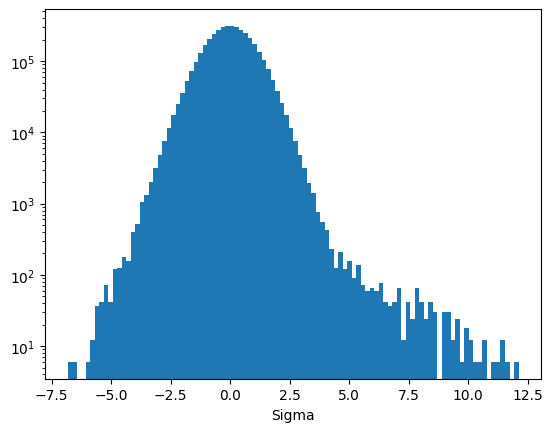

In [20]:
plt.hist(map_value_normalized.flatten(),bins=100)
plt.yscale("log")
plt.xlabel("Sigma")
plt.show()

### Find blobs with gemmi, flood fill

In [21]:
'''
cutoff : float
    The z-score cutoff at which pixels are thresholded for peak finding.
min_volume : float (optional)
    The minimum volume of peaks which defaults to zero.
min_score : float (optional)
    The minimum score of peaks which defaults to zero. See gemmi.find_blobs_by_flood_fill
min_peak : float (optional)
    The minimum peak height of peaks which defaults to zero. See gemmi.find_blobs_by_flood_fill
negate : bool (optional)
    Optionally find peaks in the negative electron density. This can be useful for difference maps.
    The default is False.
'''
blobs = gemmi.find_blobs_by_flood_fill(diff_map, 
                                       cutoff=5.5, 
                                       min_volume=10, 
                                       min_score=0, 
                                       min_peak=7.5,
                                       negate=False)

In [22]:
len(blobs)

1

In [23]:
blob0 = blobs[0]

In [24]:
blob0.peak_value

12.113320350646973

In [25]:
raw_blobpos = blob0.centroid

### Fractionalize both blob peak and ligand position

In [26]:
cell = diff_gemmi.cell

In [27]:
# Blob positions in the diff map
raw_blobpos

<gemmi.Position(-11.3424, 61.0433, 11.3358)>

In [28]:
frac_blobpos = cell.fractionalize(raw_blobpos)

In [29]:
frac_blobpos

<gemmi.Fractional(0.266042, 0.784589, 0.106445)>

In [30]:
# Use the centroid of ligand as the position
lig_pos = lig_centroid

In [31]:
lig_pos

array([-30.886     ,  23.25720588, -12.17888235])

In [32]:
frac_ligpos = cell.fractionalize(gemmi.Position(*lig_pos))

In [33]:
frac_ligpos

<gemmi.Fractional(-0.19433, 0.298925, -0.114362)>

### Apply all symmetry oprations

In [34]:
def applysymop(frac_pos, unitcell, spacegroup,
               incell=True, orthogonal=False):
    '''
    Apply symmetry operations to real space asu model coordinates
    Parameters
    ----------
    frac_pos: np.array, fractional position
    
    unitcell: gemmi.UnitCell
    
    spacegroup: gemmi.SpaceGroup
    
    incell: Boolean, move into cell
    
    orthogonal: Boolean, return orthogonal coordinates
    '''
    operations = spacegroup.operations()  # gemmi.GroupOps object
    R_G_array_stack = np.stack([np.array(
        sym_op.rot)/sym_op.DEN for sym_op in operations], axis=0)
    T_G_array_stack = np.stack([np.array(
            sym_op.tran)/sym_op.DEN for sym_op in operations], axis=0)
    sym_oped_pos_frac = np.transpose(np.matmul(R_G_array_stack, 
                                               frac_pos.T),[2,0,1]) + T_G_array_stack

    if incell:
        sym_oped_pos_frac = sym_oped_pos_frac % 1
    if orthogonal:
        frac2orth_array = np.array(unitcell.orthogonalization_matrix.tolist())
        sym_oped_pos_orth = np.dot(
            sym_oped_pos_frac, frac2orth_array.T)
        return sym_oped_pos_orth
    else:
        return sym_oped_pos_frac

In [35]:
sg = diff_map.spacegroup

In [36]:
frac_ligpos_arr = np.array(frac_ligpos.tolist())[None,:]

In [37]:
frac_blobpos_arr = np.array(frac_blobpos.tolist())[None,:] 

In [38]:
ligpos_symoped = applysymop(frac_ligpos_arr, cell, sg, incell=True, orthogonal=True)[0]

In [39]:
blobpos_symoped = applysymop(frac_blobpos_arr, cell, sg, incell=True, orthogonal=True)[0]

In [40]:
dis_matrix = np.sqrt(np.sum((ligpos_symoped[None,...] - blobpos_symoped[:,None,:])**2, axis=-1))

In [41]:
dis_matrix

array([[115.12952177,  57.18132783,  81.02836962,   2.7257911 ,
         76.46577324,  43.34276897],
       [ 78.77140977,  48.60738078,  45.5620986 ,  43.4409826 ,
         43.34276897,   2.7257911 ],
       [ 57.83238914,  67.10287471,  52.8982054 ,  74.0226191 ,
          2.7257911 ,  43.4409826 ],
       [  2.7257911 ,  76.46577324,  43.34276897, 115.12952177,
         57.18132783,  81.02836962],
       [ 43.4409826 ,  43.34276897,   2.7257911 ,  78.77140977,
         48.60738078,  45.5620986 ],
       [ 74.0226191 ,   2.7257911 ,  43.4409826 ,  57.83238914,
         67.10287471,  52.8982054 ]])

In [42]:
np.min(dis_matrix)

2.7257910999914388

^^^ The distance between blob centroid and ground truth ligand center of mass is 2.72A, which I believe could be taken as we found the correct place

### Do some neighbor search around blobs to verify

In [43]:
ns = gemmi.NeighborSearch(bound_pdb[0], cell, 5).populate()

In [44]:
marks = ns.find_atoms(blob0.centroid)

In [45]:
marks

VectorMarkPtr[0x562b27a205b0, 0x562b27a205d0, 0x562b27a47080, 0x562b27a470a0, 0x562b27a47140, 0x562b27a471a0, 0x562b27a47280, 0x562b27a472a0, 0x562b27a472c0, 0x562b27a472e0, 0x562b27a47bc0, 0x562b27a47be0, 0x562b27a47c00, 0x562b27a47c20, 0x562b27a47c40, 0x562b27a47c60, 0x562b27a47c80, 0x562b27a47cc0, 0x562b27a47d00, 0x562b27a47d20, 0x562b27a47d80, 0x562b27a47dc0, 0x562b27a47de0, 0x562b27a47f40, 0x562b27a47f60, 0x562b27a459e0, 0x562b27a45a60, 0x562b27a25db0, 0x562b27ca1690, 0x562b27ca16f0, 0x562b279b21b0, 0x562b279b21d0, 0x562b279b21f0, 0x562b279b2210, 0x562b27a5b340, 0x562b27a5b360, 0x562b27a5b380, 0x562b27a5b3a0, 0x562b27a5b3c0, 0x562b27a5b3e0, 0x562b27a5b400, 0x562b27a5b420, 0x562b27a5b440, 0x562b27a5b460, 0x562b27a5b480, 0x562b27abc180]

In [46]:
mark0 = marks[0]

In [47]:
cra = mark0.to_cra(bound_pdb[0])

In [48]:
cra

<gemmi.CRA A/ARG 105/HA>

In [49]:
for mark in marks:
    cra = mark.to_cra(bound_pdb[0])
    print(cra)

A/ARG 105/HA
A/ARG 105/HB2
A/ARG 169/CG
A/ARG 169/CD
A/ARG 169/HG2
A/ARG 169/HD3
B/LIG 1/C14
B/LIG 1/C15
B/LIG 1/F17
B/LIG 1/H151
A/ARG 105/CD
A/ARG 105/NE
A/ARG 105/CZ
A/ARG 105/NH2
A/ARG 105/HD2
A/ARG 105/HD3
A/ARG 105/HH21
A/ARG 169/CB
A/ARG 169/HB3
A/GLU 170/N
A/GLU 170/O
A/GLU 170/H
A/GLU 170/HB3
B/LIG 1/C16
B/LIG 1/H161
A/ARG 169/CA
A/ARG 169/HA
A/HIS 208/HD1
A/HIS 208/CE1
A/HIS 208/HE1
B/LIG 1/C12
B/LIG 1/C13
B/LIG 1/H121
B/LIG 1/H131
B/LIG 1/C04
B/LIG 1/C06
B/LIG 1/C08
B/LIG 1/C11
B/LIG 1/N05
B/LIG 1/N10
B/LIG 1/O09
B/LIG 1/H061
B/LIG 1/H062
B/LIG 1/H101
S/HOH 266/O
B/LIG 1/H042


^^^ The neighbors we found close to the blobs are ARG105 and ARG169, which are exactly correspondent with the bound PDB

<img src="./PyMol_Ligand_0049_bound.png" alt="PyMol_Ligand_0049_bound.png" width="500"/>